In [1]:
import wandb
import pandas as pd
import torch
import numpy as np

In [2]:
project_name = 'human-chromhmm-fullstack'

In [3]:
wandb.login(host="https://api.wandb.ai")

wandb: Currently logged in as: avantikalal (grelu). Use `wandb login --relogin` to force relogin


True

In [4]:
run = wandb.init(
    entity='grelu', project=project_name, job_type='training', name='train'
) 

## Load data

In [5]:
artifact = run.use_artifact('dataset:latest')
dir = artifact.download()

chromhmm = pd.read_csv(dir + '/chromhmm.csv.gz')
chromhmm['state'] = chromhmm['state'].astype('category')
chromhmm.head()

wandb:   1 of 1 files downloaded.  


,chrom,start,end,state
0,chr1,792508,793532,GapArtf
1,chr1,793908,794932,Acet
2,chr1,794408,795432,EnhWk
3,chr1,795908,796932,Quies
4,chr1,798608,799632,GapArtf


In [6]:
chromhmm.state.value_counts()

state
Quies      1485576
Acet        639669
EnhA        613794
ReprPC      610147
Tx          561526
EnhWk       543113
HET         521161
TxWk        254518
TxEnh       190465
TxEx        121833
PromF        88429
GapArtf      51474
BivProm      48242
znf          34146
TSS          24402
DNase        20609
Name: count, dtype: int64

## Downsample

In [7]:
out = pd.DataFrame()
rng = np.random.RandomState(0)

for state in chromhmm.state.unique():
    if np.sum(chromhmm.state == state) > 250000:
        out = pd.concat([out, chromhmm[chromhmm.state==state].sample(
            250000, random_state=rng)])
    else:
        out = pd.concat([out, chromhmm[chromhmm.state==state]])

chromhmm = out.reset_index(drop=True).copy()
chromhmm.state.value_counts()

state
Acet       250000
EnhA       250000
EnhWk      250000
HET        250000
Quies      250000
ReprPC     250000
Tx         250000
TxWk       250000
TxEnh      190465
TxEx       121833
PromF       88429
GapArtf     51474
BivProm     48242
znf         34146
TSS         24402
DNase       20609
Name: count, dtype: int64

## Split dataset

In [8]:
import grelu.data.preprocess 

val_chroms   = ['chr7']
test_chroms  = ['chr13']

train, val, test = grelu.data.preprocess.split(
    chromhmm,
    train_chroms=None,
    val_chroms=val_chroms,
    test_chroms=test_chroms,
)

assert set(train.state) == set(val.state) == set(test.state)
print(train.head(3))

Selecting training samples
Keeping 2353772 intervals


Selecting validation samples
Keeping 146030 intervals


Selecting test samples
Keeping 79798 intervals
Final sizes: train: (2353772, 4), val: (146030, 4), test: (79798, 4)
  chrom   start     end    state
0  chr1  792508  793532  GapArtf
1  chr1  798608  799632  GapArtf
2  chr1  889208  890232  GapArtf


## Make pytorch datasets

In [9]:
import grelu.data.dataset

train_dataset = grelu.data.dataset.DFSeqDataset(
    train, rc=True, max_seq_shift=3, 
    augment_mode="random",
    genome="hg38",
)

val_dataset = grelu.data.dataset.DFSeqDataset(
    val, genome="hg38",
)

print(train_dataset.labels.shape)
print(train_dataset.labels[:3].squeeze())

/usr/local/lib/python3.11/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Sequences will be extracted from columns ['chrom', 'start', 'end']
Labels are being treated as class names for multiclass classification.
Sequences will be extracted from columns ['chrom', 'start', 'end']
Labels are being treated as class names for multiclass classification.
(2353772, 16, 1)
[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


## Inversely weight classes

In [10]:
class_prop = chromhmm.state.value_counts(normalize=True)
class_weights = 1/class_prop
class_weights = class_weights/class_weights.sum()
class_weights

state
Acet       0.018543
EnhA       0.018543
EnhWk      0.018543
HET        0.018543
Quies      0.018543
ReprPC     0.018543
Tx         0.018543
TxWk       0.018543
TxEnh      0.024339
TxEx       0.038051
PromF      0.052424
GapArtf    0.090061
BivProm    0.096095
znf        0.135765
TSS        0.189977
DNase      0.224941
Name: proportion, dtype: float64

In [11]:
# reorder according to the dataset
class_weights = class_weights[train_dataset.tasks.index].tolist()
class_weights

[0.01854327493563345,
 0.09609507760682316,
 0.22494146896542108,
 0.01854327493563345,
 0.01854327493563345,
 0.09006136561969855,
 0.01854327493563345,
 0.05242419041161115,
 0.01854327493563345,
 0.01854327493563345,
 0.18997699917663974,
 0.01854327493563345,
 0.024339478297368874,
 0.03805059986956213,
 0.01854327493563345,
 0.13576462056780772]

## Build model

In [15]:
model_params = {
    'model_type':'EnformerPretrainedModel',
    'n_tasks': len(chromhmm.state.unique()),
    'crop_len': 0,
    'n_transformers': 1,
}

train_params = {
    'task':'multiclass',
    'lr':2e-4,
    'logger': 'wandb',
    'batch_size': 512,
    'num_workers': 16,
    'devices': 4,
    'save_dir': project_name,
    'optimizer': 'adam',
    'max_epochs': 10,
    'class_weights':class_weights,
}

import grelu.lightning
model = grelu.lightning.LightningModel(model_params=model_params, train_params=train_params) 

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.
wandb: Downloading large artifact human_state_dict:latest, 939.29MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:2.3


## Train model

In [16]:
trainer = model.train_on_dataset(train_dataset, val_dataset)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/pytorch_lightning/loggers/wandb.py:396: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Validation DataLoader 0: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 286/286 [00:39<00:00,  7.19it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │    0.07444832473993301    │
│         val_auroc         │    0.5337527990341187     │
│        val_avgprec        │    0.07467257231473923    │
│         val_loss          │    0.07976853102445602    │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]

  | Name         | Type                    | Params
---------------------------------------------------------
0 | model        | EnformerPretrainedModel | 71.5 M
1 | loss         | CrossEntropyLoss        | 0     
2 | activation   | Softmax                 | 0     
3 | val_metrics  | MetricCollection        | 0     
4 | test_metrics | MetricCollection        | 0     
5 | transform    | Identity                | 0     
---------------------------------------------------------
71.5 M    Trainable params
0         Non-trainable params
71.5 M    Total params
285.968   Total estimated model params size (MB)


Epoch 0: 100%|████████████████████████████████████████████████████████████████████████████████████| 4598/4598 [56:12<00:00,  1.36it/s, v_num=4lva, train_loss_step=0.0404]
Validation: |                                                                                                                                       | 0/? [00:00<?, ?it/s]
Epoch 1:  58%|██████████████████████████████████▎                        | 2672/4598 [40:10<28:57,  1.11it/s, v_num=4lva, train_loss_step=0.0444, train_loss_epoch=0.0479]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Epoch 9:  85%|██████████████████████████████████████████████████▎        | 3923/4598 [58:28<10:03,  1.12it/s, v_num=4lva, train_loss_step=0.0415, train_loss_epoch=0.0389]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



## Load best checkpoint

In [17]:
best_checkpoint = trainer.checkpoint_callback.best_model_path
print(best_checkpoint)
model = grelu.lightning.LightningModel.load_from_checkpoint(best_checkpoint)

human-chromhmm-fullstack/lightning_logs/sqcu4lva/checkpoints/epoch=8-step=41382.ckpt


wandb: WARNING Calling wandb.login() after wandb.init() has no effect.
wandb: Downloading large artifact human_state_dict:latest, 939.29MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:2.3


## Evaluate model

In [18]:
test_dataset = grelu.data.dataset.DFSeqDataset(
    test,
    genome="hg38",
)

test_metrics = model.test_on_dataset(
    test_dataset, devices=0, num_workers=16, batch_size=512
)
test_metrics

Sequences will be extracted from columns ['chrom', 'start', 'end']
Labels are being treated as class names for multiclass classification.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing DataLoader 0: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:21<00:00,  7.28it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.4539305865764618     │
│        test_auroc         │    0.8721814155578613     │
│       test_avgprec        │    0.41437748074531555    │
│         test_loss         │   0.044250160455703735    │
└───────────────────────────┴───────────────────────────┘

,test_accuracy,test_auroc,test_avgprec
Acet,0.399460,0.812190,0.321723
BivProm,0.473013,0.936125,0.332317
DNase,0.876588,0.989962,0.754356
EnhA,0.333157,0.833828,0.405787
EnhWk,0.382038,0.822116,0.394104
GapArtf,0.767707,0.951515,0.627946
HET,0.408386,0.869615,0.543314
PromF,0.609283,0.953951,0.560607
Quies,0.333945,0.839267,0.453530
ReprPC,0.213686,0.762107,0.215000


In [19]:
test_metrics.sort_values("test_avgprec")

,test_accuracy,test_auroc,test_avgprec
znf,0.414153,0.860495,0.086424
ReprPC,0.213686,0.762107,0.215000
TxEnh,0.259815,0.826215,0.262565
TxWk,0.187271,0.782581,0.275718
TxEx,0.492576,0.908820,0.293008
Acet,0.399460,0.812190,0.321723
Tx,0.333380,0.811955,0.324290
BivProm,0.473013,0.936125,0.332317
EnhWk,0.382038,0.822116,0.394104
EnhA,0.333157,0.833828,0.405787


In [20]:
probs = model.predict_on_dataset(test_dataset, devices=0, num_workers=16, batch_size=1024)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting DataLoader 0: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:20<00:00,  3.77it/s]


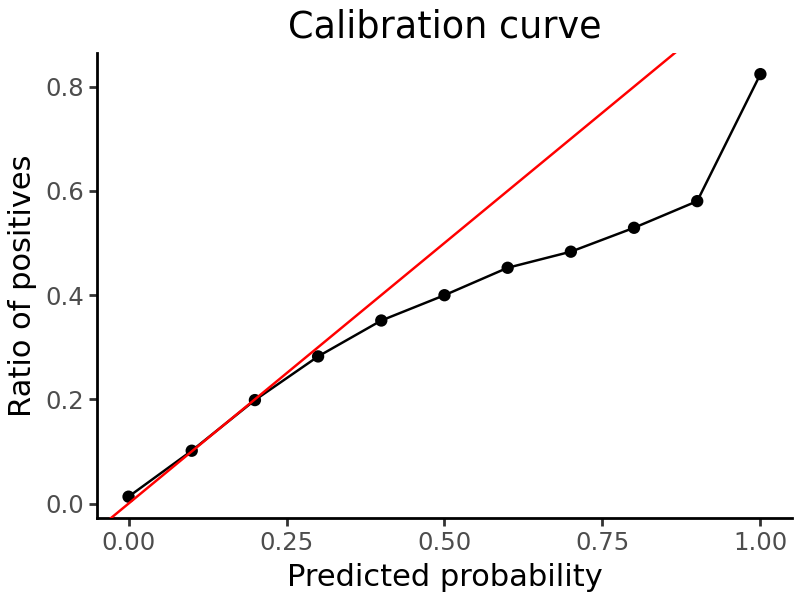

In [21]:
import grelu.visualize

grelu.visualize.plot_calibration_curve(
    probs,
    test_dataset.labels,
    figsize=(4,3)
)

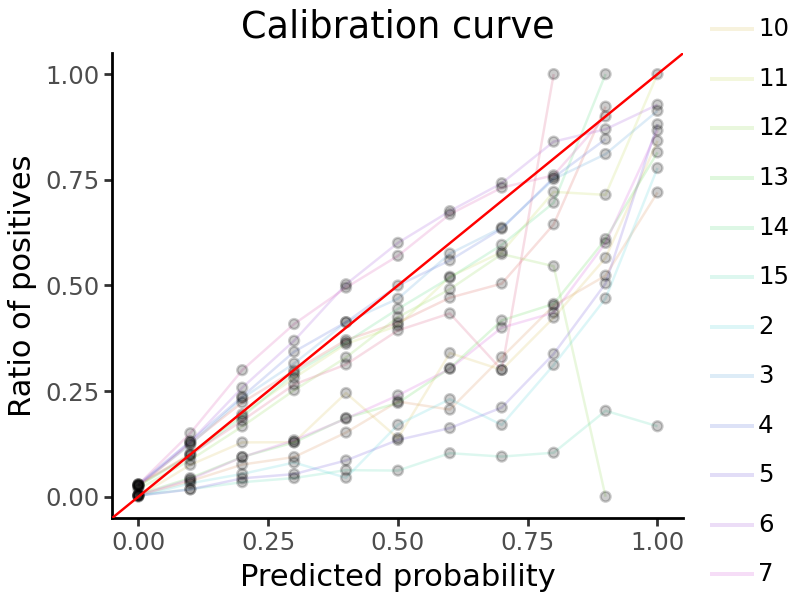

In [22]:
grelu.visualize.plot_calibration_curve(
    probs, test_dataset.labels,
    aggregate=False, figsize=(4,3)
       )

## Save

In [23]:
artifact = wandb.Artifact('model', type='model') # use type=model to upload models
artifact.add_file(best_checkpoint, 'model.ckpt') # use model.ckpt as a filename
run.log_artifact(artifact)

<Artifact model>

In [24]:
run.finish()

epoch,▁▁▁▁▁▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇████
train_loss_epoch,█▆▅▅▄▃▃▂▂▁
train_loss_step,█▄▄▇▆▅▄▄▇▅▃▄▄▃▃▃▃▂▃▅▂▂▄▄▂▄▄▃▂▂▃▄▁▂▁▄▂▂▂▂
trainer/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
val_accuracy,▁▁▅▆▇▇▇█████
val_auroc,▁▂▆▇▇███████
val_avgprec,▁▁▅▇▇▇██████
val_loss,██▄▃▂▂▁▁▁▁▁▁
epoch,9
train_loss_epoch,0.03816
train_loss_step,0.03586
